Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [2]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    #feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 550]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = pd.read_csv('Correct_train_26.csv', sep=';')
#for_ml = get_for_learn_clean_df(pd.read_csv('Test_set_best.csv', sep=';'))
#for_ml = for_ml[for_ml['wellName'] != 'cgr402']
display(for_ml.describe())
display(for_ml)
for_ml = get_for_learn_clean_df(for_ml)
wells_samples_df = get_well_dfs(for_ml)
print('count wells', len(wells_samples_df))

MD           AGR           ANK           ASP             BK  \
count  76607.000000  76607.000000  29765.000000  70937.000000   55246.000000   
mean    2353.214897    -44.562323    -27.052799    -65.401031      10.872462   
std      370.353201    669.537726    527.326694    807.788110    1086.810230   
min     1632.000000  -9999.000000  -9999.000000  -9999.000000   -9999.000000   
25%     2050.200000      0.256430      0.757234      0.042691       5.512000   
50%     2356.600000      0.471532      0.871735      0.154018       7.000000   
75%     2611.000000      0.670175      0.969732      0.449210       8.700000   
max     3270.900000      1.000000      1.000000      1.000000  116144.860000   

             Facies    Facies_LIT            GR           LIT          NKTB  \
count  76607.000000  76607.000000  76607.000000  72200.000000  76607.000000   
mean   -9317.115773  -9827.553970    -43.660359  -6210.348019   -605.917083   
std     2521.149203   1298.309152    732.985269   4851.373635   2393.551852   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    -9999.000000  -9999.000000      7.376250  -9999.000000      3.280200   
50%    -9999.000000  -9999.000000      9.430000  -9999.000000      3.720000   
75%    -9999.000000  -9999.000000     11.631000      1.000000      4.260000   
max       12.000000     12.000000    108.920000      6.000000     24.130000   

                 SP  
count  75344.000000  
mean       3.180176  
std     1026.643341  
min    -9999.000000  
25%       76.137385  
50%      107.808500  
75%      140.206750  
max      218.061000

wellName datasetName      MD       AGR  ANK     ASP        BK  Facies  \
0      spk1036   TrainLogs  1720.0  0.433027  NaN -9999.0 -9999.000   -9999   
1      spk1036   TrainLogs  1720.2  0.390320  NaN -9999.0 -9999.000   -9999   
2      spk1036   TrainLogs  1720.4  0.317364  NaN -9999.0 -9999.000   -9999   
3      spk1036   TrainLogs  1720.6  0.256863  NaN -9999.0 -9999.000   -9999   
4      spk1036   TrainLogs  1720.8  0.235510  NaN -9999.0 -9999.000   -9999   
...        ...         ...     ...       ...  ...     ...       ...     ...   
76602  spk432R   TrainLogs  2664.4  0.234586  1.0     0.0     5.869   -9999   
76603  spk432R   TrainLogs  2664.6  0.274610  1.0     0.0     6.166   -9999   
76604  spk432R   TrainLogs  2664.8  0.203586  1.0     0.0     7.917   -9999   
76605  spk432R   TrainLogs  2665.0  0.107808  1.0     0.0     8.308   -9999   
76606  spk432R   TrainLogs  2665.2  0.110353  1.0     0.0     8.206   -9999   

       Facies_LIT      GR  LAYER     LIT     NKTB        SP  
0           -9999   7.210  -9999 -9999.0  2.09000 -9999.000  
1           -9999   7.450  -9999 -9999.0  2.14000 -9999.000  
2           -9999   7.860  -9999 -9999.0  2.16000 -9999.000  
3           -9999   8.200  -9999 -9999.0  2.12000 -9999.000  
4           -9999   8.320  -9999 -9999.0  2.11000 -9999.000  
...           ...     ...    ...     ...      ...       ...  
76602       -9999  14.252     U1     1.0  3.15011   198.362  
76603       -9999  13.906     U1     1.0  3.06579   198.828  
76604       -9999  14.520     U1     1.0  2.98865   198.490  
76605       -9999  15.348     U1     1.0  2.54313   198.255  
76606       -9999  15.326     U1     1.0  2.50426   198.267  

[76607 rows x 14 columns]

['spk1036' 'spk1150' 'spk1518' 'spk1519' 'spk1521' 'spk1527' 'spk1743'
 'spk1746' 'spk1747' 'spk1749PL' 'spk1750PL' 'spk1768' 'spk1769'
 'spk1779PL' 'spk1799PL' 'spk400' 'spk403' 'spk405R' 'spk409R' 'spk420R'
 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L' 'spk432R']
count wells 26


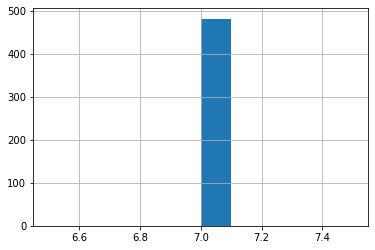

In [3]:
for_ml[for_ml['Facies'] == 7]['Facies'].hist()

In [4]:
for_ml[for_ml['Facies'] == 7]['wellName'].unique()

array(['spk1519', 'spk1521', 'spk1527', 'spk1749PL', 'spk400', 'spk424R',
       'spk429L'], dtype=object)

In [5]:
wells_samples_df[7]

wellName      MD          AGR  ANK          ASP     BK  Facies  \
21482  spk1746  1685.0     0.750140  NaN     0.649053  6.175   -9999   
21483  spk1746  1685.2     0.739108  NaN     0.668145  6.274   -9999   
21484  spk1746  1685.4     0.939866  NaN     0.694172  6.374   -9999   
21485  spk1746  1685.6     1.000000  NaN     0.722242  6.388   -9999   
21486  spk1746  1685.8     0.885325  NaN     0.731986  6.321   -9999   
...        ...     ...          ...  ...          ...    ...     ...   
26377  spk1746  2664.0 -9999.000000  NaN -9999.000000  0.000   -9999   
26378  spk1746  2664.2 -9999.000000  NaN -9999.000000  0.000   -9999   
26379  spk1746  2664.4 -9999.000000  NaN -9999.000000  0.000   -9999   
26380  spk1746  2664.6 -9999.000000  NaN -9999.000000  0.000   -9999   
26381  spk1746  2664.8 -9999.000000  NaN -9999.000000  0.000   -9999   

       Facies_LIT        GR  LAYER     LIT      NKTB         SP  
21482       -9999     6.857  -9999 -9999.0     3.043    89.8328  
21483       -9999     6.928  -9999 -9999.0     3.295    88.3378  
21484       -9999     5.636  -9999 -9999.0     3.191    86.2998  
21485       -9999     5.182  -9999 -9999.0     3.171    84.1018  
21486       -9999     5.987  -9999 -9999.0     3.219    83.3388  
...           ...       ...    ...     ...       ...        ...  
26377       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26378       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26379       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26380       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26381       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  

[4900 rows x 13 columns]

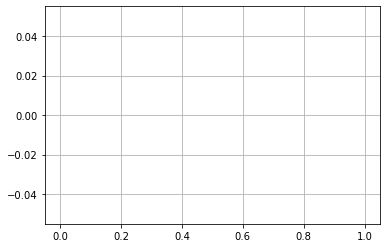

In [6]:
wells_samples_df[7][wells_samples_df[7]['Facies'] > 0]['Facies'].hist()

In [7]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1
        #min_ = well_copy[name_feature_extraction].min()
        #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
            #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x - abs(min_))
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        
#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower
        del well_copy[name_feature_extraction]
        well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
well_with_features = get_well_with_features_df_intervals(well_with_features, ['GR'], [0.2])

SP_0
SP_1


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\iteration2\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


SP_2
SP_3


TypeError: 'int' object is not iterable

In [8]:




def change_facies(x):
    return x
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = pd.concat(wells_samples_df)

for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
for_ml_preprocessing = for_ml_preprocessing.fillna(-9999)


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    del well_copy['Facies_LIT']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = for_ml_preprocessing#get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LAYER']
    del feature['Facies_LIT']
    #del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

AGR           ANK           ASP             BK        Facies  \
count  76607.000000  76607.000000  76607.000000   76607.000000  76607.000000   
mean     -44.562323  -6124.484506   -800.627657   -2780.267847  -9317.115773   
std      669.537726   4871.646834   2714.258965    4582.636500   2521.149203   
min    -9999.000000  -9999.000000  -9999.000000   -9999.000000  -9999.000000   
25%        0.256430  -9999.000000      0.026181   -9999.000000  -9999.000000   
50%        0.471532  -9999.000000      0.131855       5.900000  -9999.000000   
75%        0.670175      0.811621      0.409422       7.900000  -9999.000000   
max        1.000000      1.000000      1.000000  116144.860000     12.000000   

         Facies_LIT            GR           LIT            MD          NKTB  \
count  76607.000000  76607.000000  76607.000000  76607.000000  76607.000000   
mean   -9827.553970    -43.660359  -6428.299242   2353.214897   -605.917083   
std     1298.309152    732.985269   4791.670148    370.353201   2393.551852   
min    -9999.000000  -9999.000000  -9999.000000   1632.000000  -9999.000000   
25%    -9999.000000      7.376250  -9999.000000   2050.200000      3.280200   
50%    -9999.000000      9.430000  -9999.000000   2356.600000      3.720000   
75%    -9999.000000     11.631000      1.000000   2611.000000      4.260000   
max       12.000000    108.920000      6.000000   3270.900000     24.130000   

                 SP  
count  76607.000000  
mean    -161.723208  
std     1630.595217  
min    -9999.000000  
25%       75.065360  
50%      107.300000  
75%      139.762000  
max      218.061000

AGR     ANK     ASP        BK      GR     LIT     NKTB        SP
0      0.433027 -9999.0 -9999.0 -9999.000   7.210 -9999.0  2.09000 -9999.000
1      0.390320 -9999.0 -9999.0 -9999.000   7.450 -9999.0  2.14000 -9999.000
2      0.317364 -9999.0 -9999.0 -9999.000   7.860 -9999.0  2.16000 -9999.000
3      0.256863 -9999.0 -9999.0 -9999.000   8.200 -9999.0  2.12000 -9999.000
4      0.235510 -9999.0 -9999.0 -9999.000   8.320 -9999.0  2.11000 -9999.000
...         ...     ...     ...       ...     ...     ...      ...       ...
76602  0.234586     1.0     0.0     5.869  14.252     1.0  3.15011   198.362
76603  0.274610     1.0     0.0     6.166  13.906     1.0  3.06579   198.828
76604  0.203586     1.0     0.0     7.917  14.520     1.0  2.98865   198.490
76605  0.107808     1.0     0.0     8.308  15.348     1.0  2.54313   198.255
76606  0.110353     1.0     0.0     8.206  15.326     1.0  2.50426   198.267

[76607 rows x 8 columns]

In [9]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    rfe = RFE(model, 4)
    rfe = rfe.fit(X_train, y_train)
    p(y_test, rfe.predict(X_test))
    p_cross_val(rfe, train, labels)
    return rfe

logistic_regression(features, target_facies)  

logistic_regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KeyboardInterrupt: 

In [10]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 6709286.381716921
              precision    recall  f1-score   support

       -9999       0.93      1.00      0.97     21443
           0       0.00      0.00      0.00       335
           1       0.00      0.00      0.00        62
           2       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        63
           5       0.00      0.00      0.00       821
           7       0.00      0.00      0.00       122
           8       0.00      0.00      0.00        41
          10       0.00      0.00      0.00        16
          12       0.00      0.00      0.00        59

    accuracy                           0.93     22983
   macro avg       0.09      0.10      0.10     22983
weighted avg       0.87      0.93      0.90     22983

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       -9999       0.93      0.94      0.93     71385
           0       0.00      0.00      0.00      1164
           1       0.00      0.00      0.00       211
           2       0.00      0.00      0.00        65
           4       0.00      0.00      0.00       190
           5       0.00      0.00      0.00      2685
           7       0.00      0.00      0.00       481
           8       0.00      0.00      0.00       142
          10       0.00      0.00      0.00        55
          12       0.00      0.00      0.00       229

    accuracy                           0.88     76607
   macro avg       0.09      0.09      0.09     76607
weighted avg       0.86      0.88      0.87     76607



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [11]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

       -9999       0.99      0.99      0.99     21437
           0       0.59      0.61      0.60       343
           1       0.48      0.36      0.41        72
           2       0.88      0.79      0.83        19
           4       0.58      0.55      0.57        71
           5       0.73      0.75      0.74       792
           7       0.64      0.65      0.65       125
           8       0.51      0.46      0.48        46
          10       0.24      0.36      0.29        11
          12       0.45      0.39      0.42        67

    accuracy                           0.96     22983
   macro avg       0.61      0.59      0.60     22983
weighted avg       0.96      0.96      0.96     22983

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

       -9999       0.97      0.88      0.92     71385
           0       0.17      0.21      0.19      1164
           1       0.02      0

KeyboardInterrupt: 

In [39]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 0.023149693934335004
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17898
           7       0.85      0.78      0.81        72

    accuracy                           1.00     17970
   macro avg       0.92      0.89      0.91     17970
weighted avg       1.00      1.00      1.00     17970

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      0.97      0.98     59651
           7       0.06      0.45      0.11       247

    accuracy                           0.97     59898
   macro avg       0.53      0.71      0.55     59898
weighted avg       0.99      0.97      0.98     59898



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True,criterion='entropy',
            n_estimators=100, n_jobs=-1,warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

       -9999       1.00      1.00      1.00     57392
           0       1.00      1.00      1.00       334
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00      1590
           7       1.00      1.00      1.00       247
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        38
          12       1.00      1.00      1.00       100

    accuracy                           1.00     59898
   macro avg       1.00      1.00      1.00     59898
weighted avg       1.00      1.00      1.00     59898

cross_val_predict
              precision    recall  f1-score   support

       -9999       0.97      0.85      0.91     57392
           0       0.53      0.54      0.53       334
           1       0.89      0.74     

In [40]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 2)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.011574846967167502
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17898
           7       0.98      0.83      0.90        72

    accuracy                           1.00     17970
   macro avg       0.99      0.92      0.95     17970
weighted avg       1.00      1.00      1.00     17970

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     59651
           7       0.84      0.38      0.52       247

    accuracy                           1.00     59898
   macro avg       0.92      0.69      0.76     59898
weighted avg       1.00      1.00      1.00     59898



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=18, verbose=0,
                       warm_start=False)

In [76]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    print(cat_features)
    print(train)
    cv_dataset = Pool(data=train,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.95)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = catboost_pool = Pool(X_train, 
                                 y_train,
                                     cat_features=cat_features)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test,
                                    cat_features=cat_features)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='MultiClassOneVsAll',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

#     params = {"iterations": 100,
#               #"depth": 5,
#               "loss_function": "Logloss",
#               "verbose": False}

#     scores = cv(cv_dataset,
#                 params,
#                 fold_count=10, 
#                 plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='MultiClassOneVsAll',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model

catBoost_prod_100 = get_catBoost_iterations(features, target_facies, 100)
catBoost_prod_152 = get_catBoost_iterations(features, target_facies, 152)
catBoost_prod_200 = get_catBoost_iterations(features, target_facies, 200)

RMSE ошибка равна 4173265.6448228597
              precision    recall  f1-score   support

       -9999       0.96      1.00      0.98     54531
           0       0.00      0.00      0.00       323
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00      1497
           7       0.00      0.00      0.00       233
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        37
          12       0.00      0.00      0.00        99

    accuracy                           0.96     56904
   macro avg       0.10      0.10      0.10     56904
weighted avg       0.92      0.96      0.94     56904

[5]
               AGR          ANK          ASP       BK       GR   LIT     NKTB  \
0     -9999.000000 -9999.000000 -9999.000000     4.71 -9999.00 -9999 -9999.00   
1     -9999.000000 -9999.000000 -9999.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RMSE ошибка равна 4102916.976750316
              precision    recall  f1-score   support

       -9999       0.96      1.00      0.98     54531
           0       0.00      0.00      0.00       323
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        62
           5       0.85      0.02      0.04      1497
           7       0.00      0.00      0.00       233
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        37
          12       0.00      0.00      0.00        99

    accuracy                           0.96     56904
   macro avg       0.18      0.10      0.10     56904
weighted avg       0.94      0.96      0.94     56904

[5]
               AGR          ANK          ASP       BK       GR   LIT     NKTB  \
0     -9999.000000 -9999.000000 -9999.000000     4.71 -9999.00 -9999 -9999.00   
1     -9999.000000 -9999.000000 -9999.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RMSE ошибка равна 3462835.3739104457
              precision    recall  f1-score   support

       -9999       0.97      1.00      0.98     54531
           0       0.00      0.00      0.00       323
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        62
           5       0.66      0.24      0.35      1497
           7       1.00      0.08      0.14       233
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        37
          12       0.00      0.00      0.00        99

    accuracy                           0.96     56904
   macro avg       0.26      0.13      0.15     56904
weighted avg       0.95      0.96      0.95     56904

[5]
               AGR          ANK          ASP       BK       GR   LIT     NKTB  \
0     -9999.000000 -9999.000000 -9999.000000     4.71 -9999.00 -9999 -9999.00   
1     -9999.000000 -9999.000000 -9999.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    cv_dataset = get_cb_data_all(train, labels)

    params = {"iterations": 100,
              #"depth": 5,
              "loss_function": "MultiClassOneVsAll",
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=10, 
                plot="True")
    params = {'iterations':100, 'loss_function':'MultiClassOneVsAll'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

[5]
               AGR          ANK          ASP       BK       GR   LIT     NKTB  \
0     -9999.000000 -9999.000000 -9999.000000     4.71 -9999.00 -9999 -9999.00   
1     -9999.000000 -9999.000000 -9999.000000     4.61 -9999.00 -9999 -9999.00   
2         0.447642     1.000000     0.454160     4.36     9.52 -9999     3.43   
17        0.703655     0.880955     0.587900    26.29     7.16 -9999     6.42   
18        0.760064     0.798636     0.533957    24.63     6.64 -9999     7.45   
...            ...          ...          ...      ...      ...   ...      ...   
73682 -9999.000000 -9999.000000 -9999.000000 -9999.00 -9999.00     1     3.37   
73683 -9999.000000 -9999.000000 -9999.000000 -9999.00 -9999.00     1     3.61   
73684 -9999.000000 -9999.000000 -9999.000000 -9999.00 -9999.00     1     3.95   
73685 -9999.000000 -9999.000000 -9999.000000 -9999.00 -9999.00     1     3.98   
73686 -9999.000000 -9999.000000 -9999.000000 -9999.00 -9999.00     1 -9999.00   

               SP  inte

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

# Предсказываем значения

In [52]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature

dataset_for_predict = get_clean_df(pd.read_csv('Test_set_best.csv', sep=';'))
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['cgr1205L' 'cgr146R' 'cgr1508' 'cgr1515' 'cgr1517' 'cgr1528' 'cgr1529'
 'cgr1537' 'cgr1650PL' 'cgr1654PL' 'cgr1656PL' 'cgr1700' 'cgr1701'
 'cgr1702' 'cgr1703' 'cgr1704' 'cgr1705' 'cgr1707' 'cgr1710' 'cgr1718'
 'cgr1725' 'cgr1740' 'cgr1741' 'cgr1742' 'cgr1745L' 'cgr1753' 'cgr1755'
 'cgr1760' 'cgr1764' 'cgr1765']


In [53]:

well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['SP'], [0.2])
well_with_features_prod = get_well_with_features_df_intervals(well_with_features_prod, ['GR'], [0.2])


SP_0
SP_1
SP_2
SP_3
SP_4
SP_5


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\iteration2\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
SP_18
SP_19
SP_20
SP_21
SP_22
SP_23
SP_24
SP_25
SP_26
SP_27
SP_28
SP_29
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
GR_27
GR_28
GR_29
0


In [55]:
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

AGR       ANK       ASP     BK      GR  LAYER   LIT      MD  \
9236    0.850218  0.727724  0.134764  22.16  4.8000  -9999 -9999  1850.2   
9237    0.887429  0.633109  0.114327  29.10  4.5700  -9999 -9999  1850.4   
9238    0.725643  0.713389  0.103360   9.22  5.5700  -9999 -9999  1850.6   
9244    0.484582  1.000000  0.064585   4.72  7.0600  -9999 -9999  1851.8   
9245    0.461932  1.000000  0.067820   4.86  7.2000  -9999 -9999  1852.0   
...          ...       ...       ...    ...     ...    ...   ...     ...   
299194  0.057459  0.875767  1.000000   9.48  9.3456    NaN -9999  3127.2   
299195  0.076063  0.828847  1.000000   9.25  9.2304    NaN -9999  3127.4   
299196  0.022576  0.843444  1.000000   9.23  9.5616    NaN -9999  3127.6   
299197  0.009785  0.836146  1.000000   9.23  9.6408    NaN -9999  3127.8   
299198  0.009785  0.836146  1.000000   9.23  9.6408    NaN -9999  3128.0   

           NKTB          SP  interval_lenght_GRinterval_0.2_  \
9236    3.11000   99.514890                                3   
9237    3.44000  100.853000                                3   
9238    3.16000  101.571200                                3   
9244    1.91000  104.110100                                2   
9245    1.98000  103.898300                                2   
...         ...         ...                              ...   
299194  2.89940    7.255928                                3   
299195  3.13880    7.255928                                3   
299196  3.06432    7.255928                                3   
299197  3.10156    7.255928                                3   
299198  3.10156    7.255928                                3   

        interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
9236                                  5                 5.5700   
9237                                  5                 5.5700   
9238                                  5                 5.5700   
9244                                  3                 7.2000   
9245                                  3                 7.2000   
...                                 ...                    ...   
299194                               73                 9.5616   
299195                               73                 9.5616   
299196                               73                 9.6408   
299197                               73                 9.6408   
299198                               73                 9.6408   

        max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  \
9236                 101.9975                 4.5700              99.514890   
9237                 101.9975                 4.5700              99.514890   
9238                 101.9975                 4.5700              99.514890   
9244                 104.1101                 7.0600             102.812000   
9245                 104.1101                 7.0600             102.812000   
...                       ...                    ...                    ...   
299194               125.0559                 9.2304               7.255928   
299195               125.0559                 9.2304               7.255928   
299196               125.0559                 9.5616               7.255928   
299197               125.0559                 9.5616               7.255928   
299198               125.0559                 9.5616               7.255928   

        wellName  
9236    cgr1205L  
9237    cgr1205L  
9238    cgr1205L  
9244    cgr1205L  
9245    cgr1205L  
...          ...  
299194   cgr1765  
299195   cgr1765  
299196   cgr1765  
299197   cgr1765  
299198   cgr1765  

[145193 rows x 17 columns]

In [56]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    #del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        print(x)
        return undefined_value
    if math.isnan(x):
        print(x)
        return undefined_value
    if math.isinf(x):
        print(x)
        return undefined_value
    if x > -99999:
        return int(x) 
    print(x)

for_predict_df_prod = for_ml_preprocessing_prod.dropna().fillna(-9999)
for_predict_df_prod['LIT'] = for_predict_df_prod['LIT'].apply(change_null)
#for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

In [57]:
for_predict_df

AGR       ANK       ASP     BK    GR   LIT  NKTB         SP  \
9236    0.850218  0.727724  0.134764  22.16  4.80 -9999  3.11   99.51489   
9237    0.887429  0.633109  0.114327  29.10  4.57 -9999  3.44  100.85300   
9238    0.725643  0.713389  0.103360   9.22  5.57 -9999  3.16  101.57120   
9244    0.484582  1.000000  0.064585   4.72  7.06 -9999  1.91  104.11010   
9245    0.461932  1.000000  0.067820   4.86  7.20 -9999  1.98  103.89830   
...          ...       ...       ...    ...   ...   ...   ...        ...   
298913  0.584839  0.801174  0.560843  29.14  6.08     4  3.28   89.61593   
298914  0.605834  0.775695  0.562223  23.56  5.95     4  3.41   89.52592   
298915  0.626828  0.799214  0.558084  24.65  5.82     4  3.29   89.79593   
298916  0.670432  0.828612  0.553944  20.68  5.55     4  3.14   90.06593   
298917  0.686582  0.812933  0.552105  18.38  5.45     4  3.22   90.18593   

        interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
9236                                  3                                5   
9237                                  3                                5   
9238                                  3                                5   
9244                                  2                                3   
9245                                  2                                3   
...                                 ...                              ...   
298913                               46                               83   
298914                               46                               83   
298915                               46                               83   
298916                               46                               83   
298917                               46                               83   

        max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
9236                     5.57               101.9975                   4.57   
9237                     5.57               101.9975                   4.57   
9238                     5.57               101.9975                   4.57   
9244                     7.20               104.1101                   7.06   
9245                     7.20               104.1101                   7.06   
...                       ...                    ...                    ...   
298913                  24.99               127.1731                   4.75   
298914                  24.99               127.1731                   4.75   
298915                  24.99               127.1731                   4.75   
298916                  24.99               127.1731                   4.75   
298917                  24.99               127.1731                   4.75   

        min_SPinterval_0.2_SP  
9236                 99.51489  
9237                 99.51489  
9238                 99.51489  
9244                102.81200  
9245                102.81200  
...                       ...  
298913               73.08593  
298914               73.08593  
298915               73.08593  
298916               73.08593  
298917               73.08593  

[108546 rows x 14 columns]

In [86]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset



for_predict_df_prod['catBoost_prod_200'] = catBoost_prod_200.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_152'] = catBoost_prod_152.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_100'] = catBoost_prod_100.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['random'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)

In [87]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost_prod_200']
    f_1 = row['catBoost_prod_152']
    f_3 = row['catBoost_prod_100']
    if f_0 == f_1 and f_3 == f_1:
        return f_0
    return -9999
for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [90]:
for_predict_df_prod[for_predict_df_prod['random'] != -9999]

AGR       ANK       ASP     BK    GR  LAYER  LIT      MD  NKTB  \
13481   0.644750  0.773599  0.483346  13.86  6.07  UV1_0    4  2699.2  2.95   
13482   0.685196  0.727724  0.479834  17.07  5.82  UV1_0    4  2699.4  3.11   
13483   0.777415  0.650311  0.464714  21.78  5.25  UV1_1    4  2699.6  3.38   
13484   0.814625  0.607304  0.458300  21.83  5.02  UV1_1    4  2699.8  3.53   
13485   0.712700  0.673249  0.443639  15.03  5.65  UV1_1    4  2700.0  3.30   
...          ...       ...       ...    ...   ...    ...  ...     ...   ...   
298909  0.402349  0.752177  0.422254  18.46  7.21  U1(1)    5  3070.2  3.53   
298914  0.605834  0.775695  0.562223  23.56  5.95  U1(1)    4  3071.2  3.41   
298915  0.626828  0.799214  0.558084  24.65  5.82  U1(1)    4  3071.4  3.29   
298916  0.670432  0.828612  0.553944  20.68  5.55  U1(1)    4  3071.6  3.14   
298917  0.686582  0.812933  0.552105  18.38  5.45  U1(1)    4  3071.8  3.22   

              SP  ...  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  wellName  \
13481   76.69031  ...                   5.02               76.69031  cgr1205L   
13482   76.92030  ...                   5.02               76.69031  cgr1205L   
13483   77.91031  ...                   5.02               76.69031  cgr1205L   
13484   78.33031  ...                   5.02               78.33031  cgr1205L   
13485   79.29031  ...                   5.63               78.33031  cgr1205L   
...          ...  ...                    ...                    ...       ...   
298909  98.65593  ...                   4.75               73.08593   cgr1765   
298914  89.52592  ...                   4.75               73.08593   cgr1765   
298915  89.79593  ...                   4.75               73.08593   cgr1765   
298916  90.06593  ...                   4.75               73.08593   cgr1765   
298917  90.18593  ...                   4.75               73.08593   cgr1765   

        catBoost_prod_39  catBoost_prod_52  catBoost_prod_152  \
13481                3.0               3.0            -9999.0   
13482                3.0               3.0            -9999.0   
13483                3.0               3.0            -9999.0   
13484                3.0               3.0            -9999.0   
13485                3.0               3.0            -9999.0   
...                  ...               ...                ...   
298909               3.0               3.0            -9999.0   
298914               7.0               7.0            -9999.0   
298915               7.0               7.0            -9999.0   
298916               7.0               7.0            -9999.0   
298917               7.0               7.0            -9999.0   

       catBoost_prod_100  random  catBoost  catBoost_prod_200  
13481            -9999.0       7   -9999.0            -9999.0  
13482            -9999.0       7   -9999.0            -9999.0  
13483            -9999.0       7   -9999.0                7.0  
13484            -9999.0       7   -9999.0                7.0  
13485            -9999.0       7   -9999.0            -9999.0  
...                  ...     ...       ...                ...  
298909           -9999.0       5   -9999.0                5.0  
298914           -9999.0       7   -9999.0                7.0  
298915           -9999.0       7   -9999.0                7.0  
298916           -9999.0       7   -9999.0                7.0  
298917           -9999.0       7   -9999.0                7.0  

[5228 rows x 24 columns]

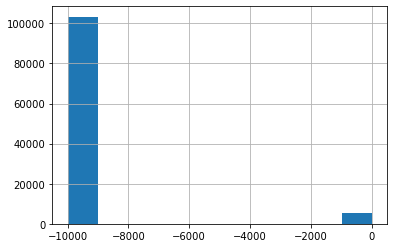

In [92]:
for_predict_df_prod['random'].hist()

In [93]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'catBoost' and 
            name_feature != 'random' and 
            name_feature != 'catBoost_prod_200' and 
            name_feature != 'catBoost_prod_152' and
            name_feature != 'catBoost_prod_100'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_all_facies_catBoost_intervals.csv', index=False)
    
save(for_predict_df_prod)

AGR
ANK
ASP
BK
GR
LIT
NKTB
SP
interval_lenght_GRinterval_0.2_
interval_lenght_SPinterval_0.2_
max_GRinterval_0.2_GR
max_SPinterval_0.2_SP
min_GRinterval_0.2_GR
min_SPinterval_0.2_SP
catBoost_prod_39
catBoost_prod_52
